In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('diabetes.csv').replace(0, np.nan)
df[['Pregnancies', 'Outcome']] = df[['Pregnancies', 'Outcome']].replace(np.nan, 0)

#df = df.fillna(df.mean())
used_cols = df.columns[df.columns != 'Outcome']
#df = df.loc[~np.any(df[used_cols].isnull(), axis = 1)]
print(df.head(10))

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0      NaN  33.6   
1          1.0     85.0           66.0           29.0      NaN  26.6   
2          8.0    183.0           64.0            NaN      NaN  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          0.0    137.0           40.0           35.0    168.0  43.1   
5          5.0    116.0           74.0            NaN      NaN  25.6   
6          3.0     78.0           50.0           32.0     88.0  31.0   
7         10.0    115.0            NaN            NaN      NaN  35.3   
8          2.0    197.0           70.0           45.0    543.0  30.5   
9          8.0    125.0           96.0            NaN      NaN   NaN   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50      1.0  
1                     0.351   31      0.0  
2                     0.672   32      1.0  
3                     0.167   2

c:\users\alanv\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


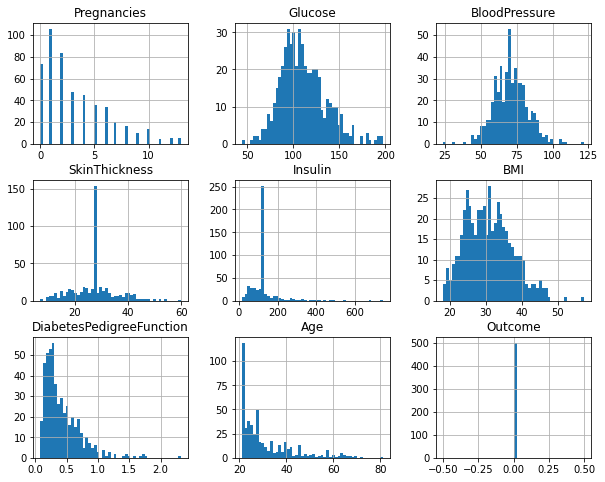

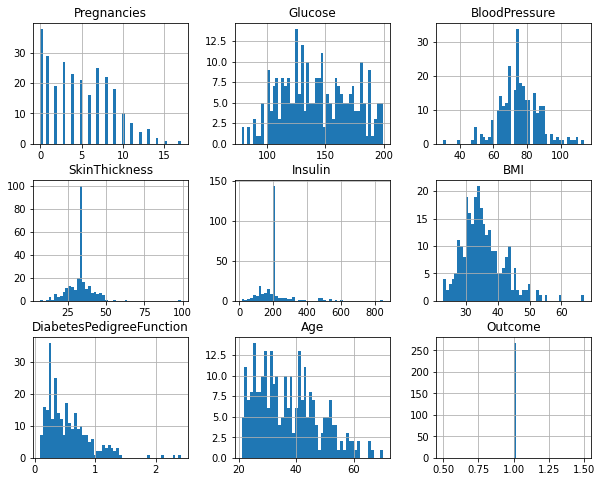

In [4]:
grouped = df.groupby('Outcome')

for row in df.index:
    df.loc[row] = df.loc[row].fillna(grouped.get_group(df.loc[row, 'Outcome']).mean())
    
grouped.hist(figsize = (10, 8), bins = 50);

In [5]:
for col in df.columns[df.columns != 'Outcome']:
    print('\n\n' + col)
    print(grouped[col].describe()) 



Pregnancies
         count      mean       std  min   25%  50%  75%   max
Outcome                                                      
0.0      500.0  3.298000  3.017185  0.0  1.00  2.0  5.0  13.0
1.0      268.0  4.865672  3.741239  0.0  1.75  4.0  8.0  17.0


Glucose
         count        mean        std   min    25%    50%    75%    max
Outcome                                                                
0.0      500.0  110.643863  24.702314  44.0   93.0  107.5  125.0  197.0
1.0      268.0  142.319549  29.488132  78.0  119.0  140.5  167.0  199.0


BloodPressure
         count       mean        std   min   25%        50%   75%    max
Outcome                                                                 
0.0      500.0  70.877339  11.927450  24.0  63.5  70.877339  78.0  122.0
1.0      268.0  75.321429  11.925638  30.0  68.0  75.321429  82.0  114.0


SkinThickness
         count       mean       std  min   25%        50%   75%   max
Outcome                                       

In [6]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129867,0.208935,0.094172,0.093546,0.024127,-0.033523,0.544341,0.221898
Glucose,0.129867,1.000000,0.224356,0.235040,0.497789,0.235253,0.138125,0.268566,0.495954
BloodPressure,0.208935,0.224356,1.000000,0.203453,0.099996,0.286518,-0.002264,0.324439,0.175087
SkinThickness,0.094172,0.235040,0.203453,1.000000,0.212573,0.565443,0.102426,0.135916,0.308094
Insulin,0.093546,0.497789,0.099996,0.212573,1.000000,0.231533,0.121716,0.165149,0.410918
BMI,0.024127,0.235253,0.286518,0.565443,0.231533,1.000000,0.152530,0.027578,0.315271
DiabetesPedigreeFunction,-0.033523,0.138125,-0.002264,0.102426,0.121716,0.152530,1.000000,0.033561,0.173844
Age,0.544341,0.268566,0.324439,0.135916,0.165149,0.027578,0.033561,1.000000,0.238356
Outcome,0.221898,0.495954,0.175087,0.308094,0.410918,0.315271,0.173844,0.238356,1.000000


In [7]:
def gen_dataset(): return train_test_split(df, test_size = 0.2, shuffle = True)

In [59]:
class Method1:
    def __init__(self, *args, **kwargs):
        self.probabilities = [{}, {}]
    
    def train(self, train_set : pd.DataFrame, grouped, used_cols : np.array) -> None:
        self.probabilities[0].clear()
        self.probabilities[1].clear()
        
        self.used_cols = used_cols
        
        for col in self.used_cols:
            g0 = grouped.get_group(0)[col].value_counts(normalize = True)
            g1 = grouped.get_group(1)[col].value_counts(normalize = True)
            
            self.probabilities[0][col] = np.array([g0.index, g0.to_numpy()])
            self.probabilities[1][col] = np.array([g1.index, g1.to_numpy()])

        self.probabilities[0]['Priori'] = 1 - train_set['Outcome'].mean()
        self.probabilities[1]['Priori'] = 1 - self.probabilities[0]['Priori']

    def _predict(self, data : pd.Series) -> int:
        nodiab = self.probabilities[0]['Priori']
        diab = self.probabilities[1]['Priori']
        
        for key, val in data.items():
            if key in self.probabilities[0] and key in self.probabilities[1]:
                diab *= self.probabilities[1][key][1][np.argmin(np.abs(val - self.probabilities[1][key][0]))]
                nodiab *= self.probabilities[0][key][1][np.argmin(np.abs(val - self.probabilities[0][key][0]))]

        return int(nodiab < diab)

    def test(self, test_set : pd.DataFrame) -> pd.Series:
        return test_set[self.used_cols].apply(self._predict, axis = 1)

In [61]:
reps = 100

params_1 = np.zeros((reps, 5))
#params_2 = params_1.copy()
trivial = params_1.copy()

def parameters(targets_ok : np.array, pred_ok : np.array) -> list[float]:
    
    acc = np.mean(targets_ok == pred_ok)
    VP = np.sum(targets_ok & pred_ok)
    VN = np.sum(~targets_ok & ~pred_ok)
    FP = np.sum(~targets_ok & pred_ok)
    FN = np.sum(targets_ok & ~pred_ok)
    
    sensib = VP / (VP + FN) if VP or FN else 0
    specif = VN / (VN + FP) if VN or FP else 0
    vpredp = VP / (VP + FP) if VP or FP else 0
    vpredn = VN / (VN + FN) if VN or FN else 0
    
    return [acc, sensib, specif, vpredp, vpredn]


method1 = Method1()
for i in range(reps):
    train, test = gen_dataset()
    
    method1.train(train, grouped, used_cols)
    
    pred_1 = method1.test(test)
    #pred_2 = test_2(test, *train_2(train))
    
    targets_ok = test['Outcome'] == 1
    pred_ok_1 = pred_1 == 1
    #pred_ok_2 = pred_2 == 1
    
    params_1[i] = parameters(targets_ok, pred_ok_1)
    #params_2[i] = parameters(targets_ok, pred_ok_2)
    
    trivial[i] = parameters(targets_ok, np.full(targets_ok.size, False))
    
def print_data(values):
    mean = lambda val: (np.mean(val) * 100).round(2) 
    print(f'\tAccuracy: {mean(values[:, 0])}%')
    print(f'\tSensib: {mean(values[:, 1])}%')
    print(f'\tSpecif: {mean(values[:, 2])}%')
    print(f'\tVpred_pos: {mean(values[:, 3])}%')
    print(f'\tVpred_neg: {mean(values[:, 4])}%')

print('Método 1:')
print_data(params_1)

#print('Método 2:')
#print_data(params_2)

print('Trivial:')
print_data(trivial)

Método 1:
	Accuracy: 88.15%
	Sensib: 93.8%
	Specif: 85.28%
	Vpred_pos: 76.88%
	Vpred_neg: 96.29%
Trivial:
	Accuracy: 65.62%
	Sensib: 0.0%
	Specif: 100.0%
	Vpred_pos: 0.0%
	Vpred_neg: 65.62%
